### CR heating rate vs. molecular cloud position

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from numpy import trapz
import math
from astropy import units as u
from astropy.constants import c, m_e, sigma_T, alpha
from aafragpy import get_cross_section

In [2]:
# magnetic field - density relation 
def B(n):
    
    n1 = 300 #cm^-3
    B_ICM = (10 * u.uG).to(u.G)
    q = 2/3
    
    if n <= n1:
        return B_ICM.value
    else:
        return B_ICM.value * (n / n1)**q

In [3]:
# density relation
def n_r(r):
    
    n_0 = 10**4 #cm^-3
    r_0 = 2 #pc
    a = -2
    
    return n_0 * (1 + (r / r_0)**2)**a

In [4]:
### proton power spectrum ###
def dN_dE(Ep, Gamma, U_CR):
    # N_0 has unit cm^-3 GeV^-1
    
    E_max = Ep[-1]
    E_min = Ep[0]
    
    if Gamma == 2:
        N_0 = (U_CR*10**-9 * E_min**(-Gamma)) / np.log(E_max / E_min)
    else:
        N_0 = (U_CR*10**-9 * (2 - Gamma) * E_min**(-Gamma)) / (E_max**(2 - Gamma) - E_min**(2 - Gamma))
    
    E_0 = 1 #GeV
    
    return N_0 * (Ep / E_0)**(-Gamma)

In [5]:
### ionization fraction ###
def x_i(n, U_CR):
    
    scale = U_CR / 1.4
    x_0 = 8.7 * 10**-8
    zeta_H = 10**-16 #1/s
    
    return x_0 * (scale * zeta_H / 10**-17)**(1/2) * (n*u.cm**-3 / (10**5*u.cm**-3))**(-1/2)

### electron heating efficiency f_c ###
def efficiency(n, E_e, U_CR):
    
    # n is in cm^-3
    n_ion = x_i(n, U_CR) * n*u.cm**-3

    # coefficient of E; change all E to [GeV]
    U_rad = 0.26*u.eV*u.cm**-3
    U_mag = ((B(n)**2 / (8 * math.pi))*u.erg*u.cm**-3).to(u.eV*u.cm**-3)
    
    K_rad = ((4/3) * sigma_T / (m_e**2 * c**3) * U_rad).to(1 / (u.GeV * u.Myr))
    K_sync = ((4/3) * sigma_T / (m_e**2 * c**3) * U_mag).to(1 / (u.GeV * u.Myr))
    K_ff = (alpha * c * sigma_T * n_ion).to(1/u.Myr)
    K_c = (30 * n_ion * m_e * c**3 * sigma_T).to(u.GeV/u.Myr)
    
    # energy loss timescale
    tau_rad = (K_rad.value * E_e)**-1
    tau_sync = (K_sync.value * E_e)**-1
    tau_ff = (K_ff.value * E_e**0)**-1
    tau_c = (K_c.value * E_e**-1)**-1

    # heating efficiency
    f_c = tau_c**-1 / (tau_c**-1 + tau_rad**-1 + tau_sync**-1 + tau_ff**-1)
   
    return f_c

#### Galaxy Parameters

In [6]:
### Galaxy Parameters ###
# Milky Way
Gamma_MW = 2.7
U_MW = 1.4 #eVcm^-3

# M82
Gamma_82 = 2.14
U_82 = 550 #eVcm^-3

# Arp 220
Gamma_220 = 2.48
U_220 = 5100 #eVcm^-3

In [7]:
def H_UV(SFR):
    return 10**-24 * (SFR / 160)

SFR_MW = 2
SFR_82 = 13
SFR_220 = 230

### 
### Milky Way

In [9]:
# molecular cloud radius
r_array = np.linspace(0, 2, 30)          ### 0 - 2 pc

# "threshold energy" 
E_thr = 4   ### in GeV

# proton energy; size j
E_p = np.logspace(0, 6, 50)              ### 1e0 - 1e6 GeV
E_p_array = E_p[E_p > E_thr]

# dNp/dEp (proton spectral number density)
####### change Gamma and U_CR #######
p_spectralMW = dN_dE(E_p_array, Gamma_MW, U_MW)     ### in cm^-3 GeV^-1

# electron energy
#size i
E_e_array = np.logspace(-3, 6, 30)        ### 1e-3 - 1e6 GeV

# differential cross section in mb/GeV
dsigma_dEe = get_cross_section ('el','p-p', E_primaries = E_p_array, E_secondaries = E_e_array)
# size jxi
cross_section = dsigma_dEe[0] * 10**-27  ### in cm^2 GeV^-1

# final heating power
resultsMW = np.zeros_like(r_array)

for k in np.arange(len(r_array)):
    n = n_r(r_array[k])
    
    outerMW = np.zeros_like(E_p_array)
    
    for j in np.arange(len(E_p_array)):
        dNp_dEpMW = p_spectralMW[j]
        
        innerMW = np.zeros_like(E_e_array)
    
        for i in np.arange(len(E_e_array)): 
            E_e = E_e_array[i]
        
            diff_sigma = cross_section[j,i]
            ####### change U_CR #######
            f_cMW = efficiency(n, E_e, U_MW)
        
            innerMW[i] = E_e * f_cMW * n * diff_sigma * c.to(u.cm/u.s).value * dNp_dEpMW  
            
        int_innerMW = trapz(innerMW, E_e_array)
        outerMW[j] = int_innerMW
        
    int_outerMW = trapz(outerMW, E_p_array)
    resultsMW[k] = int_outerMW

H_MW = (resultsMW * u.GeV*u.cm**-3*u.s**-1).to(u.erg*u.cm**-3*u.s**-1)
print(H_MW)

[2.40112239e-29 2.39953471e-29 2.39478632e-29 2.38692078e-29
 2.37600945e-29 2.36214961e-29 2.34546207e-29 2.32608825e-29
 2.30418692e-29 2.27993075e-29 2.25350276e-29 2.22509292e-29
 2.19489480e-29 2.16310257e-29 2.12990830e-29 2.09549959e-29
 2.06005764e-29 2.02375565e-29 1.98675759e-29 1.94921738e-29
 1.91127826e-29 1.87307252e-29 1.83472144e-29 1.79633537e-29
 1.75801406e-29 1.71984697e-29 1.68191380e-29 1.64428503e-29
 1.60702244e-29 1.57017978e-29] erg / (cm3 s)


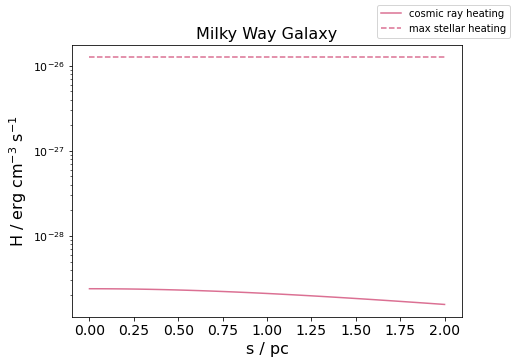

In [48]:
fig, ax = plt.subplots(figsize=[7,5]) 

ax.plot(r_array, H_MW, color = 'palevioletred', label = 'cosmic ray heating')
ax.plot(r_array, H_UV(SFR_MW)*r_array**0, color = 'palevioletred', linestyle = '--', label = 'max stellar heating')
ax.set_yscale('log')
ax.set_ylabel('H / erg cm$^{-3}$ s$^{-1}$', fontsize = 16)
ax.set_xlabel('s / pc', fontsize = 16)
ax.set_title('Milky Way Galaxy', fontsize = 16)
ax.tick_params(axis='x', which='major', labelsize = 14)
ax.tick_params(axis='y', which='major', labelsize = 11)
fig.legend()
plt.savefig('Milky Way.pdf')

### 
### M82

In [15]:
# molecular cloud radius
r_array = np.linspace(0, 2, 30)          ### 0 - 2 pc

# "threshold energy" 
E_thr = 4   ### in GeV

# proton energy; size j
E_p = np.logspace(0, 6, 50)              ### 1e0 - 1e6 GeV
E_p_array = E_p[E_p > E_thr]

# dNp/dEp (proton spectral number density)
####### change Gamma and U_CR #######
p_spectral82 = dN_dE(E_p_array, Gamma_82, U_82)     ### in cm^-3 GeV^-1

# electron energy
#size i
E_e_array = np.logspace(-3, 6, 30)        ### 1e-3 - 1e6 GeV

# differential cross section in mb/GeV
dsigma_dEe = get_cross_section ('el','p-p', E_primaries = E_p_array, E_secondaries = E_e_array)
# size jxi
cross_section = dsigma_dEe[0] * 10**-27  ### in cm^2 GeV^-1

# final heating power
results82 = np.zeros_like(r_array)

for k in np.arange(len(r_array)):
    n = n_r(r_array[k])
    
    outer82 = np.zeros_like(E_p_array)
    
    for j in np.arange(len(E_p_array)):
        dNp_dEp82 = p_spectral82[j]
        
        inner82 = np.zeros_like(E_e_array)
    
        for i in np.arange(len(E_e_array)): 
            E_e = E_e_array[i]
        
            diff_sigma = cross_section[j,i]
            ####### change U_CR #######
            f_c82 = efficiency(n, E_e, U_82)
        
            inner82[i] = E_e * f_c82 * n * diff_sigma * c.to(u.cm/u.s).value * dNp_dEp82  
            
        int_inner82 = trapz(inner82, E_e_array)
        outer82[j] = int_inner82
        
    int_outer82 = trapz(outer82, E_p_array)
    results82[k] = int_outer82

H_82 = (results82 * u.GeV*u.cm**-3*u.s**-1).to(u.erg*u.cm**-3*u.s**-1)
print(H_82)

[1.01903288e-25 1.01799108e-25 1.01487774e-25 1.00972871e-25
 1.00260253e-25 9.93578844e-26 9.82756126e-26 9.70249068e-26
 9.56185641e-26 9.40703994e-26 9.23949330e-26 9.06070855e-26
 8.87218927e-26 8.67542466e-26 8.47186686e-26 8.26291184e-26
 8.04988399e-26 7.83402430e-26 7.61648203e-26 7.39830939e-26
 7.18045916e-26 6.96378446e-26 6.74904066e-26 6.53688867e-26
 6.32789955e-26 6.12255986e-26 5.92127761e-26 5.72438855e-26
 5.53216251e-26 5.34480976e-26] erg / (cm3 s)


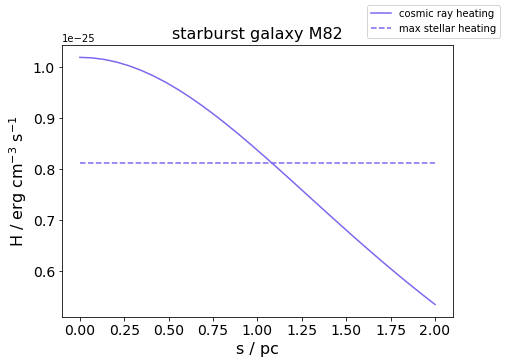

In [47]:
fig, ax = plt.subplots(figsize=[7,5]) 

ax.plot(r_array, H_82, color = 'mediumslateblue', label = 'cosmic ray heating')
ax.plot(r_array, H_UV(SFR_82)*r_array**0, color = 'mediumslateblue', linestyle = '--', label = 'max stellar heating')
#plt.yscale('log')
ax.set_ylabel('H / erg cm$^{-3}$ s$^{-1}$', fontsize = 16)
ax.set_xlabel('s / pc', fontsize = 16)
ax.set_title('starburst galaxy M82', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize = 14)
fig.legend()
plt.savefig('M82.pdf')

### 
### Arp 220

In [19]:
# molecular cloud radius
r_array = np.linspace(0, 2, 30)          ### 0 - 2 pc

# "threshold energy" 
E_thr = 4   ### in GeV

# proton energy; size j
E_p = np.logspace(0, 6, 50)              ### 1e0 - 1e6 GeV
E_p_array = E_p[E_p > E_thr]

# dNp/dEp (proton spectral number density)
####### change Gamma and U_CR #######
p_spectral220 = dN_dE(E_p_array, Gamma_220, U_220)     ### in cm^-3 GeV^-1

# electron energy
#size i
E_e_array = np.logspace(-3, 6, 30)        ### 1e-3 - 1e6 GeV

# differential cross section in mb/GeV
dsigma_dEe = get_cross_section ('el','p-p', E_primaries = E_p_array, E_secondaries = E_e_array)
# size jxi
cross_section = dsigma_dEe[0] * 10**-27  ### in cm^2 GeV^-1

# final heating power
results220 = np.zeros_like(r_array)

for k in np.arange(len(r_array)):
    n = n_r(r_array[k])
    
    outer220 = np.zeros_like(E_p_array)
    
    for j in np.arange(len(E_p_array)):
        dNp_dEp220 = p_spectral220[j]
        
        inner220 = np.zeros_like(E_e_array)
    
        for i in np.arange(len(E_e_array)): 
            E_e = E_e_array[i]
        
            diff_sigma = cross_section[j,i]
            ####### change U_CR #######
            f_c220 = efficiency(n, E_e, U_220)
        
            inner220[i] = E_e * f_c220 * n * diff_sigma * c.to(u.cm/u.s).value * dNp_dEp220  
            
        int_inner220 = trapz(inner220, E_e_array)
        outer220[j] = int_inner220
        
    int_outer220 = trapz(outer220, E_p_array)
    results220[k] = int_outer220

H_220 = (results220 * u.GeV*u.cm**-3*u.s**-1).to(u.erg*u.cm**-3*u.s**-1)
print(H_220)

[2.14135841e-24 2.13878275e-24 2.13108883e-24 2.11837484e-24
 2.10080099e-24 2.07858467e-24 2.05199393e-24 2.02133988e-24
 1.98696813e-24 1.94924989e-24 1.90857306e-24 1.86533361e-24
 1.81992761e-24 1.77274406e-24 1.72415884e-24 1.67452954e-24
 1.62419162e-24 1.57345544e-24 1.52260440e-24 1.47189395e-24
 1.42155130e-24 1.37177590e-24 1.32274030e-24 1.27459152e-24
 1.22745265e-24 1.18142462e-24 1.13658817e-24 1.09300573e-24
 1.05072338e-24 1.00977273e-24] erg / (cm3 s)


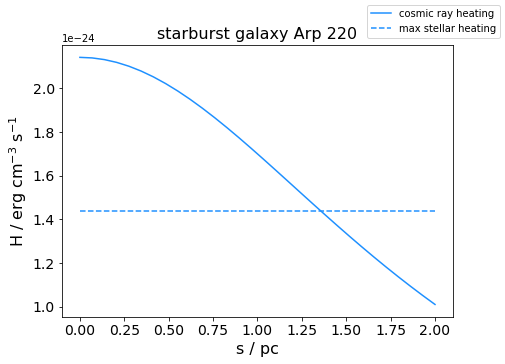

In [46]:
fig, ax = plt.subplots(figsize=[7,5]) 

ax.plot(r_array, H_220, color = 'dodgerblue', label = 'cosmic ray heating')
ax.plot(r_array, H_UV(SFR_220)*r_array**0, color = 'dodgerblue', linestyle = '--', label = 'max stellar heating')
#plt.yscale('log')
ax.set_ylabel('H / erg cm$^{-3}$ s$^{-1}$', fontsize = 16)
ax.set_xlabel('s / pc', fontsize = 16)
ax.set_title('starburst galaxy Arp 220', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize = 14)
fig.legend()
plt.savefig('Arp 220.pdf')

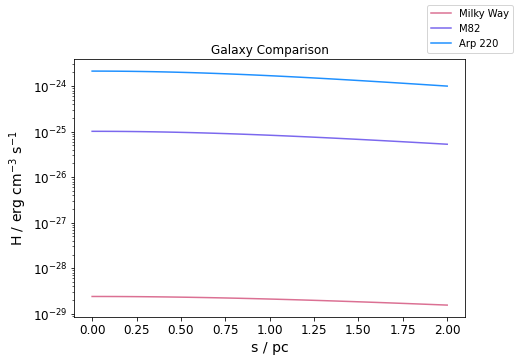

In [78]:
fig, ax = plt.subplots(figsize=[7,5]) 

ax.plot(r_array, H_MW, color = 'palevioletred', label = 'Milky Way')
#plt.plot(r_array, H_UV(SFR_MW)*r_array**0, color = 'palevioletred', linestyle = '--')

ax.plot(r_array, H_82, color = 'mediumslateblue', label = 'M82')
#plt.plot(r_array, H_UV(SFR_82)*r_array**0, color = 'mediumslateblue', linestyle = '--')

ax.plot(r_array, H_220, color = 'dodgerblue', label = 'Arp 220')
#plt.plot(r_array, H_UV(SFR_220)*r_array**0, color = 'dodgerblue', linestyle = '--')

ax.set_yscale('log')
ax.set_ylabel('H / erg cm$^{-3}$ s$^{-1}$', fontsize = 14)
#plt.ylim(10**-30, 10**-22)
ax.set_xlabel('s / pc', fontsize = 14)
ax.set_title('Galaxy Comparison')
ax.tick_params(axis='both', which='major', labelsize = 12)

fig.subplots_adjust(top = 0.84)
fig.legend()
plt.savefig('Galaxy Comparison.pdf')